#Генеративные модели на примере MNIST 

Генеративное моделирование определяет способ создания набора данных. Он пытается понять распределение точек данных, обеспечивая модель того, как данные фактически генерируются в терминах вероятностной модели. (например, машины опорных векторов или алгоритм персептрона дает разделяющую границу решения, но не модель генерации точек синтетических данных). Цель состоит в том, чтобы сгенерировать новые образцы из того, что уже было распределено в обучающих данных.

Планировалось сделать 2 модели: VAE и Conditional VAE.

Но более трое суток ушло на полследнюю (но поднять переписать так VAE не получилось а по 2 гайдам и 3 обзорам используют модуль который в не ставится в colab)

###Установка зависимостей

In [1]:
!pip install tensorflow-probability

# to generate gifs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ty29osdn
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-ty29osdn
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=155802 sha256=eab9324e8bf62afe286e4132b5656333ac4b0b14bdd334e3f0191503d2db4cf8
  Stored in directory: /tmp/pip-ephem-wheel-cache-obk48sf4/wheels/cc/c4/d8/5341e93b6376c5c929c49469fce21155eb69cef1a4da4ce32c
Successfully built tensorflow-docs


###Импорт модулей

In [2]:
from IPython import display

import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers, utils 
import time

#Параметры
train_size = 60000
batch_size = 32
test_size = 10000

###Загрузка датасета

In [3]:
(x_train_images, y_train_images), (x_test_images, y_test_images) = tf.keras.datasets.mnist.load_data() 

11501568/11490434 [==============================] - 0s 0us/step


Предобрабока изображений

In [4]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > .5, 1.0, 0.0).astype('float32')

train_images = preprocess_images(x_train_images)
test_images = preprocess_images(x_test_images)

Создание тренеровочной и тестовой выборки

In [5]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images)
                 .shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images)
                .shuffle(test_size).batch(batch_size))

train_cat = utils.to_categorical(y_train_images).astype(np.float32)
test_cat  = utils.to_categorical(y_test_images).astype(np.float32)
num_classes = test_cat.shape[1]

##Convolutional VAE
VAE - это вероятностный подход к [автоэнкодеру](https://www.tensorflow.org/tutorials/generative/autoencoder). Умными словами VAE — это генеративная модель, которая применяет априор к скрытым векторам, так что все они лежат на гауссовой плоскости или имеют гауссов профиль (предшествующий распределению представлений). Вместо того, чтобы наносить изображение на точку в пространстве, кодировщик VAE отображает изображение на все распределение (многомерное нормальное или гауссово распределение). Затем он произвольно выбирает точку из этого распределения для восстановления изображения. Это помогает ему узнать, как распределяются данные.

Еще можно прествить это так:

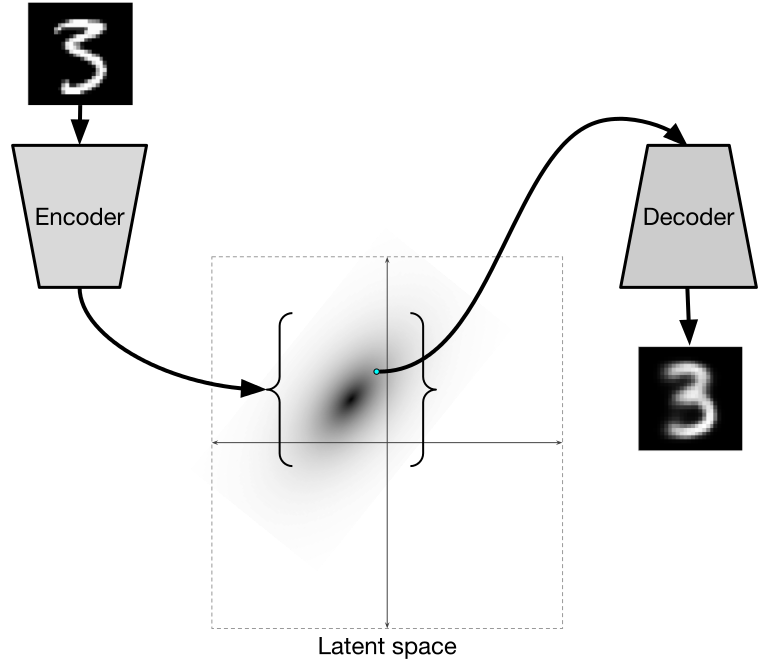

Картинка [отсюда](https://ijdykeman.github.io/ml/2016/12/21/cvae.html)

In [6]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            # No activation
            tf.keras.layers.Dense(latent_dim + latent_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
            tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=3, strides=2, padding='same',
                activation='relu'),
            # No activation
            tf.keras.layers.Conv2DTranspose(
                filters=1, kernel_size=3, strides=1, padding='same'),
        ]
    )

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits

Определение функцию потерь и оптимизатора

Оптимизаторы - это расширенный класс, который включает дополнительную информацию для обучения конкретной модели. Класс оптимизатора инициализируется с заданными параметрами, но важно помнить, что тензор не требуется. Оптимизаторы используются для повышения скорости и производительности при обучении конкретной модели.

In [7]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

###Обучение модели

In [8]:
epochs = 10

latent_dim = 4
num_examples_to_generate = 16

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

Генерация и сохранение изображений

In [9]:
def generate_and_save_images(model, epoch, test_sample):
  mean, logvar = model.encode(test_sample)
  z = model.reparameterize(mean, logvar)
  predictions = model.sample(z)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(predictions[i, :, :, 0], cmap='gray')
    plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  # plt.show()

In [10]:
assert batch_size >= num_examples_to_generate
for test_batch in test_dataset.take(1):
  test_sample = test_batch[0:num_examples_to_generate, :, :, :]

Epoch: 1, Test set ELBO (чем больше тем лучше): -162.01515197753906, time elapse for current epoch: 10.158438920974731
Epoch: 2, Test set ELBO (чем больше тем лучше): -145.99746704101562, time elapse for current epoch: 9.045453548431396
Epoch: 3, Test set ELBO (чем больше тем лучше): -139.0798797607422, time elapse for current epoch: 8.743093490600586
Epoch: 4, Test set ELBO (чем больше тем лучше): -135.61480712890625, time elapse for current epoch: 8.803107023239136
Epoch: 5, Test set ELBO (чем больше тем лучше): -133.6151123046875, time elapse for current epoch: 8.858831882476807
Epoch: 6, Test set ELBO (чем больше тем лучше): -132.0443115234375, time elapse for current epoch: 8.782319784164429
Epoch: 7, Test set ELBO (чем больше тем лучше): -130.96481323242188, time elapse for current epoch: 8.661143779754639
Epoch: 8, Test set ELBO (чем больше тем лучше): -130.19586181640625, time elapse for current epoch: 8.69273328781128
Epoch: 9, Test set ELBO (чем больше тем лучше): -129.263290

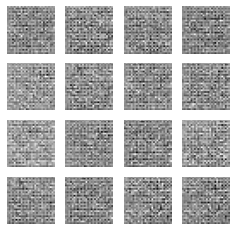

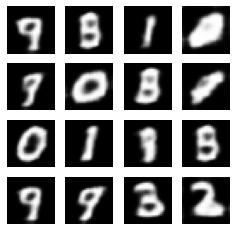

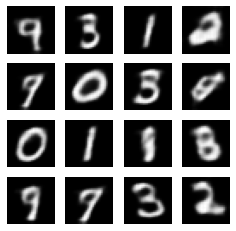

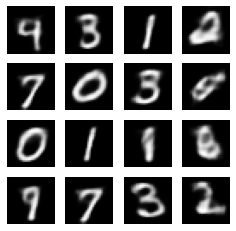

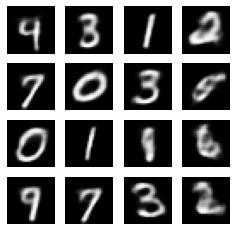

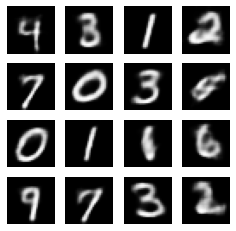

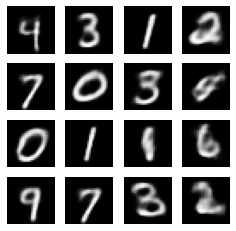

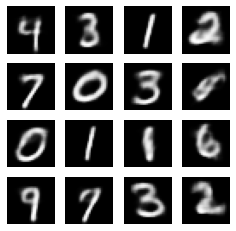

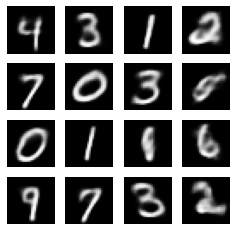

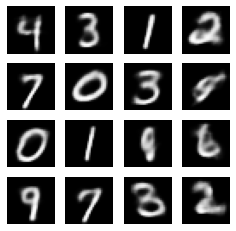

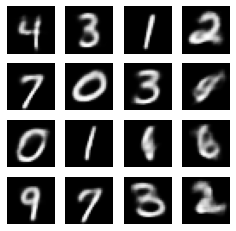

In [11]:
generate_and_save_images(model, 0, test_sample)

for epoch in range(1, epochs + 1):
  start_time = time.time()
  for train_x in train_dataset:
    train_step(model, train_x, optimizer)
  end_time = time.time()

  loss = tf.keras.metrics.Mean()
  for test_x in test_dataset:
    loss(compute_loss(model, test_x))
  elbo = -loss.result()
  # display.clear_output(wait=False)
  print('Epoch: {}, Test set ELBO (чем больше тем лучше): {}, time elapse for current epoch: {}'
        .format(epoch, elbo, end_time - start_time))
  generate_and_save_images(model, epoch, test_sample)

###Result

Ниже мы выводим все эпохи обучения как анимацию


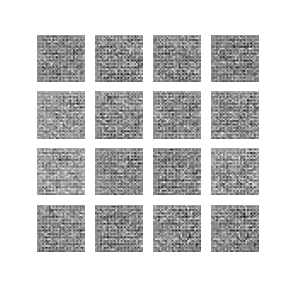

In [12]:
anim_file = 'cvae.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

###Отображение двумерного множества цифр
По документации должно работать но не работает

In [13]:
def plot_latent_images(model, n, digit_size=28):
  """Plots n x n digit images decoded from the latent space."""

  norm = tfp.distributions.Normal(0, 1)
  grid_x = norm.quantile(np.linspace(0.05, 0.95, n))
  grid_y = norm.quantile(np.linspace(0.05, 0.95, n))
  image_width = digit_size*n
  image_height = image_width
  image = np.zeros((image_height, image_width))

  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
      z = np.array([[xi, yi]])
      x_decoded = model.sample(z)
      digit = tf.reshape(x_decoded[0], (digit_size, digit_size))
      image[i * digit_size: (i + 1) * digit_size,
            j * digit_size: (j + 1) * digit_size] = digit.numpy()

  plt.figure(figsize=(10, 10))
  plt.imshow(image, cmap='Greys_r')
  plt.axis('Off')
  plt.show()

plot_latent_images(model, 20)

ValueError: ignored

#Источники:
https://tproger.ru/translations/scikit-learn-in-python/

https://waksoft.susu.ru/2021/07/08/generativnaya-i-diskriminaczionnaya-modeli/

https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

https://www.tensorflow.org/tutorials/generative/cvae

https://keras.io/examples/generative/vae/

https://github.com/hwalsuklee/tensorflow-mnist-CVAE

https://ijdykeman.github.io/ml/2016/12/21/cvae.html

#МЕМЕ
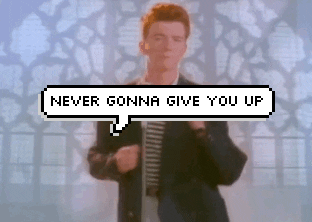

# Ревью
## Строков Дмитрий 
Первую часть прошёл, пытался разобраться с ошибкой, так в итоге и не хватило времени :(